In [1]:
#install dependencies 
!pip install SPARQLWrapper
!pip install -U pandas

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 231 kB 9.7 MB/s eta 0:00:01
     |████████████████████████████████| 45 kB 176 kB/s  eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 9.9 MB 6.7 MB/s eta 0:00:01
ERROR: swifter 1.0.7 has requirement tqdm>=4.33.0, but you'll have tqdm 4.15.0 which is incompatible.
ERROR: modin 0.8.3 has requirement pandas==1.1.5, but you'll have pandas 1.2.4 which is incompatible.
ERROR: fastparquet 0.5.0 has requirement numba>=0.49, but you'll have numba 0.48.0 which is incompatible.


In [2]:
import pandas as pd
import requests
import sys
from SPARQLWrapper import SPARQLWrapper, JSON
from tqdm import tqdm
import time
import numpy as np

now  = pd.Timestamp.now()

## 1) First approach: exploit Wikidata backlinks

In [215]:
endpoint_url = "https://query.wikidata.org/sparql"

def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
    # TODO adjust user agent; see https://w.wiki/CX6
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()


Below we have some queries that get all WikiData items for the following:
* List of Political Parties in Turkey
* List of Coup d'Etats or subcategories of Coup d'Etats in Turkey (gets also attempted coups or coup plans)
* List of all elections in Turkey
* List of all Turkish Politicians
* List of censorship related events in Turkey
* List of conflicts in Turkey
* List of Cabinets governing Turkey

In [11]:
political_organisations_query=  """
                                    # political organistaions
                                    SELECT DISTINCT ?item ?itemLabel ?sitelinks
                                    WHERE
                                    {
                                      ?item wdt:P31 wd:Q7278;  wdt:P17 wd:Q43; 
                                                           wikibase:sitelinks ?sitelinks.
                                      SERVICE wikibase:label { #BabelRainbow
                                        bd:serviceParam wikibase:language "[AUTO_LANGUAGE],fr,ar,be,bg,bn,ca,cs,da,de,el,en,es,et,fa,fi,he,hi,hu,hy,id,it,ja,jv,ko,nb,nl,eo,pa,pl,pt,ro,ru,sh,sk,sr,sv,sw,te,th,tr,uk,yue,vec,vi,zh"
                                      }
                                    }
                                    ORDER BY desc (?sitelinks)
                                """

coup_detats_query = """
                        # Turkey coup-d'etats
                        SELECT DISTINCT?item ?itemLabel ?sitelinks 
                        WHERE
                        {
                          ?item wdt:P31/wdt:P279* wd:Q45382; wdt:P17 wd:Q43;
                                    wikibase:sitelinks ?sitelinks.
                          SERVICE wikibase:label { #BabelRainbow
                            bd:serviceParam wikibase:language "[AUTO_LANGUAGE],fr,ar,be,bg,bn,ca,cs,da,de,el,en,es,et,fa,fi,he,hi,hu,hy,id,it,ja,jv,ko,nb,nl,eo,pa,pl,pt,ro,ru,sh,sk,sr,sv,sw,te,th,tr,uk,yue,vec,vi,zh"
                          }
                        }
                        ORDER BY ?sitelinks 
                    """

elections_query = """
                    # Turkey elections
                    SELECT DISTINCT ?item ?itemLabel ?sitelinks 
                    WHERE
                    {
                      ?item wdt:P31/wdt:P279* wd:Q40231; wdt:P17 wd:Q43;
                                wikibase:sitelinks ?sitelinks.
                      SERVICE wikibase:label { #BabelRainbow
                        bd:serviceParam wikibase:language "[AUTO_LANGUAGE],fr,ar,be,bg,bn,ca,cs,da,de,el,en,es,et,fa,fi,he,hi,hu,hy,id,it,ja,jv,ko,nb,nl,eo,pa,pl,pt,ro,ru,sh,sk,sr,sv,sw,te,th,tr,uk,yue,vec,vi,zh"
                      }
                    }
                    ORDER BY ?sitelinks 
                  """

politicians_query = """
                        # Turkey politicians
                        SELECT DISTINCT ?item ?itemLabel ?sitelinks
                        WHERE
                        {
                          ?item wdt:P31 wd:Q5; wdt:P27 wd:Q43; wdt:P106 wd:Q82955;
                                    wikibase:sitelinks ?sitelinks.
                          SERVICE wikibase:label { #BabelRainbow
                            bd:serviceParam wikibase:language "[AUTO_LANGUAGE],fr,ar,be,bg,bn,ca,cs,da,de,el,en,es,et,fa,fi,he,hi,hu,hy,id,it,ja,jv,ko,nb,nl,eo,pa,pl,pt,ro,ru,sh,sk,sr,sv,sw,te,th,tr,uk,yue,vec,vi,zh"
                          }
                        }
                        ORDER BY ?sitelinks 
                    """

censorship_query = """

#censorship in turkey

SELECT DISTINCT ?item  ?itemLabel ?sitelinks 
WHERE
{
  ?item wdt:P31/wdt:P279* wd:Q1185409;
            wikibase:sitelinks ?sitelinks.

   

  SERVICE wikibase:label { #BabelRainbow
    bd:serviceParam wikibase:language "[AUTO_LANGUAGE],fr,ar,be,bg,bn,ca,cs,da,de,el,en,es,et,fa,fi,he,hi,hu,hy,id,it,ja,jv,ko,nb,nl,eo,pa,pl,pt,ro,ru,sh,sk,sr,sv,sw,te,th,tr,uk,yue,vec,vi,zh"
  }
}
ORDER BY ?sitelinks 

"""

conflicts_and_events_query = """
#Turkey conflicts and events

SELECT DISTINCT ?item ?itemLabel ?sitelinks 
WHERE
{
  ?item wdt:P31/wdt:P279* wd:Q180684; wdt:P17 wd:Q43;
            wikibase:sitelinks ?sitelinks.
  ?item wdt:P585 ?date FILTER (?date > "1900-01-01T00:00:00Z"^^xsd:dateTime) .

   

  SERVICE wikibase:label { #BabelRainbow
    bd:serviceParam wikibase:language "[AUTO_LANGUAGE],fr,ar,be,bg,bn,ca,cs,da,de,el,en,es,et,fa,fi,he,hi,hu,hy,id,it,ja,jv,ko,nb,nl,eo,pa,pl,pt,ro,ru,sh,sk,sr,sv,sw,te,th,tr,uk,yue,vec,vi,zh"
  }
}
ORDER BY ?sitelinks 
"""

cabinets_query = """
# cabinets of turkey

SELECT DISTINCT ?item ?itemLabel ?sitelinks 
WHERE
{
  ?item wdt:P31/wdt:P279* wd:Q640506; wdt:P17 wd:Q43;
            wikibase:sitelinks ?sitelinks.

   

  SERVICE wikibase:label { #BabelRainbow
    bd:serviceParam wikibase:language "tr"
  }
}
ORDER BY ?sitelinks 
"""

In [12]:
queries = [{"name": "parties", "query" : political_organisations_query},
           {"name": "coups", "query" : coup_detats_query},
           {"name": "elections", "query" : elections_query},
           {"name": "politicians", "query" : politicians_query},
           {"name": "censorship", "query" : censorship_query},
           {"name": "conflicts", "query" : conflicts_and_events_query},
           {"name": "cabinets", "query" : cabinets_query}
           ]

In [13]:
items_df = pd.DataFrame()

In [14]:
for q in tqdm(queries):    
    name = q['name']
    query = q['query']
    results = get_results(endpoint_url, query)
    df = pd.io.json.json_normalize(results['results']['bindings'])
    df['name'] = name
    items_df = items_df.append(df)

  0%|          | 0/7 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """
100%|██████████| 7/7 [00:10<00:00,  1.33s/it]


In [15]:
item_ids = items_df['item.value'].str.split('/').apply(lambda x: x[-1])

In [17]:
whatLinks = []
QswhatLinks = []

for item in item_ids:
    # Turkish Political History
    url = f'https://www.wikidata.org/w/api.php?action=query&format=json&list=backlinks&bltitle={item}&bllimit=500&blnamespace=0'
    response = requests.get(url=url).json()
    whatLinks.extend(response['query']['backlinks'])

    while 'continue' in response:
        url = url + '&blcontinue='+ response['continue']['blcontinue']
        response = requests.get(url=url).json()
        whatLinks.extend(response['query']['backlinks'])

    QswhatLinks.extend([v['title'] for v in whatLinks])


In [18]:
QswhatLinks_copy = QswhatLinks.copy()

In [19]:
QswhatLinks = set(QswhatLinks)

In [20]:
len(QswhatLinks)

6518

In [21]:
allStatements = pd.DataFrame()

In [22]:
sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
#https://w.wiki/KvX (Thanks User:Dipsacus_fullonum)
# All statements with item, property, value and rank with COVID-19 (Q84263196) as value for qualifier.

for item in tqdm(item_ids):
    
    incomplete = True
    tries = 5
    
    query = """
    SELECT ?item ?itemLabel ?property ?propertyLabel ?value ?valueLabel ?rank ?qualifier ?qualifierLabel
    WHERE
    {
      ?item ?claim ?statement.
      ?property wikibase:claim ?claim.
      ?property wikibase:statementProperty ?sprop.
      ?statement ?sprop ?value.
      ?statement wikibase:rank ?rank. 
      ?statement ?qprop wd:"""f"""{item}"""""". # COVID-19


      ?qualifier wikibase:qualifier ?qprop.
      SERVICE wikibase:label { #BabelRainbow
        bd:serviceParam wikibase:language "[AUTO_LANGUAGE],fr,ar,be,bg,bn,ca,cs,da,de,el,en,es,et,fa,fi,he,hi,hu,hy,id,it,ja,jv,ko,nb,nl,eo,pa,pl,pt,ro,ru,sh,sk,sr,sv,sw,te,th,tr,uk,yue,vec,vi,zh"
      }
    }
    """
    
    while incomplete and tries > 0:
        try:
            # Query the API
            sparql.setQuery(query)
            sparql.setReturnFormat(JSON)
            results = sparql.query().convert()
            incomplete = False
        except:
            tries -= 1
            time.sleep(15)

        
    if incomplete:
        print("Oops, it is really failing a lot, skipping: %r" % (elem,))
        continue # not technically needed, but in case you opt to add
             # anything afterward ...
    else:
        allStatements = allStatements.append(pd.io.json.json_normalize(results['results']['bindings']))



100%|██████████| 5732/5732 [23:14<00:00,  3.40it/s]  


In [30]:
truthy = pd.DataFrame()

In [ ]:
# All truthy statements with COVID-19 (Q84263196) as value.
#https://w.wiki/KvZ (Thanks User:Dipsacus_fullonum)

for item in tqdm(item_ids):
    
    incomplete = True
    tries = 5
        
    query = """
                SELECT ?item ?itemLabel ?property ?propertyLabel
                WHERE
                {
                  ?item ?claim wd:"""f"""{item}"""""".
                  ?property wikibase:directClaim ?claim.
                    SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
                }"""
    
 
    while incomplete and tries > 0:
        try:
            # Query the API
            sparql.setQuery(query)
            sparql.setReturnFormat(JSON)
            results = sparql.query().convert()
            incomplete = False
        except:
            tries -= 1
            time.sleep(15)

        
    if incomplete:
        print("Oops, it is really failing a lot, skipping: %r" % (item,))
        continue # not technically needed, but in case you opt to add
             # anything afterward ...
    else:
        truthy = truthy.append(pd.io.json.json_normalize(results['results']['bindings']))




  0%|          | 0/5732 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead

 39%|███▉      | 2243/5732 [08:43<13:00,  4.47it/s] 

In [41]:
truthyQ = [link.split('/')[-1] for link in truthy['item.value'].tolist()]
allStatementsQ = [ link.split('/')[-1] for link in allStatements['item.value'].tolist()]
allSPARQL = set(truthyQ).union(set(allStatementsQ))

In [42]:
Q84263196AllItems  = allSPARQL.union(QswhatLinks)

In [43]:
Q84263196AllItems = Q84263196AllItems.union(set(item_ids))

In [44]:
Qs = Q84263196AllItems

## Getting Articles and relations


In [47]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]
        
wikidata_query_base = 'https://www.wikidata.org/w/api.php?action=wbgetentities&format=json&props=aliases|claims|datatype|descriptions|info|labels|sitelinks|sitelinks/urls&ids=' 
itemsInfo = {}
c = 0
for items in chunks(list(Qs),50):
    c +=50
    if c%200 ==0: print(c,'items reviewed')
    url = wikidata_query_base  + '|'.join(items)
    itemsInfo.update(requests.get(url=url).json()['entities'])

200 items reviewed
400 items reviewed
600 items reviewed
800 items reviewed
1000 items reviewed
1200 items reviewed
1400 items reviewed
1600 items reviewed
1800 items reviewed
2000 items reviewed
2200 items reviewed
2400 items reviewed
2600 items reviewed
2800 items reviewed
3000 items reviewed
3200 items reviewed
3400 items reviewed
3600 items reviewed
3800 items reviewed
4000 items reviewed
4200 items reviewed
4400 items reviewed
4600 items reviewed
4800 items reviewed
5000 items reviewed
5200 items reviewed
5400 items reviewed
5600 items reviewed
5800 items reviewed
6000 items reviewed
6200 items reviewed
6400 items reviewed
6600 items reviewed
6800 items reviewed
7000 items reviewed
7200 items reviewed
7400 items reviewed
7600 items reviewed
7800 items reviewed
8000 items reviewed
8200 items reviewed
8400 items reviewed
8600 items reviewed
8800 items reviewed


In [48]:
def getRelationships(claims,targetQs):
    '''
    This function receives a list of claims from a Wikidata Item, and a list of target Qs
    Iterating over the claims, looking for the target Qs and returning the pair Property and target Q
    For example, if it find relationship Part of (P31) of Q12323 (that is the target list)
    will return [(P31,Q3)]
    inputs:
    claims: object, result from wikidata queries like 
            'https://www.wikidata.org/w/api.php?action=wbgetentities&format=json&ids=Q5' 
    targetQs: list of str, where str are Q values 
    output:
        return a list of pairs (prop,target)
    '''
    pairs = []
    for prop, relationships in claims.items():
        for relationship in relationships:
            if 'mainsnak' in relationship:
                datatype = relationship['mainsnak'].get('datatype','')
                if datatype=='wikibase-item':
                    try: #found some cases without  id even for a wikibase-item datatype
                        Qfound = relationship['mainsnak']['datavalue']['value'].get('id','')
                        if Qfound in targetQs:
                            pairs.append([prop,targetQs[targetQs.index(Qfound)]])
                    except:
                        pass
    if not pairs:
        pairs.append(['unknown','unknown'])
    return pairs

def getValueIfWikidataItem(claim):
    '''
    this function return a list of values for a given claim, if those values point to a wikidata item
    datatype=='wikibase-item'
    input:
    claim: object
    output:
    wikidataItems: list of str
      '''
    output = []
    for relationship in claim:
        if 'mainsnak' in relationship:
            datatype = relationship['mainsnak'].get('datatype','')
            if datatype=='wikibase-item':
                Qfound = relationship['mainsnak']['datavalue']['value'].get('id','')
                output.append(Qfound)
    if not output:
        output.append('unknown')
    return output
    

In [49]:
pagesPerProject = {}
pagesPerProjectTable = {}
itemsInfoTable = {}
labelsEn = {}
for item,v in itemsInfo.items():
    itemsInfoTable[item] = {}
    try:
        itemsInfoTable[item]['item Label'] = v['labels']['en']['value']
    except:
        itemsInfoTable[item]['item Label'] = 'unknown '
    #checking if there are claims for that Q, if not claims we return an empty dict, to avoid errors
    claims = v.get('claims',{})
    if 'P31' in  claims: #getting part of to classify the item        
        itemsInfoTable[item]['Instace Of'] = getValueIfWikidataItem(claims.get('P31'))
    else:
        itemsInfoTable[item]['Instace Of'] = ['unknown']
    #find COVID-19 / COVID-19 pandemics relationships
    itemsInfoTable[item]['RelationTuple'] = getRelationships(claims,['Q81068910','Q84263196'])

    if 'sitelinks' in v:
        for wiki,data in v['sitelinks'].items():
            page = data['title']
            project ='%s.%s' %  (data['url'][8:].split('.')[0],data['url'][8:].split('.')[1]) #could be more elegant with regex           
            pagesPerProject[project] = pagesPerProject.get(project,[])
            pagesPerProject[project].append(page)
            article_link  = data['url']
            if project.split('.')[1] == 'wikipedia' or  project.split('.')[0] == 'commons': #iwlinks : https://meta.wikimedia.org/wiki/Help:Interwiki_linking
                projectcode = project.split('.')[0]
            else:
                projectcode = '%s:%s ' % (project.split('.')[1],project.split('.')[0])
            wikilink = '[[%s:%s|%s]]' % (projectcode,page,page)
            pagesPerProjectTable[article_link] = {'project':project,'page':page,'wikidataItem':item,'wikilink':wikilink}
            
            
itemsInfoTable = pd.DataFrame.from_dict(itemsInfoTable,orient='index')


In [50]:
pagesPerProjectTable = pd.DataFrame.from_dict(pagesPerProjectTable, orient='index')


In [51]:
#FINALVERSION Of pagesPerProjectTable
pagesPerProjectTable['url'] = pagesPerProjectTable.index
pagesPerProjectTable

,project,page,wikidataItem,wikilink,url
https://tr.wikipedia.org/wiki/Mehmet_%C5%9E%C3%BCkr%C3%BC_G%C3%BClez,tr.wikipedia,Mehmet Şükrü Gülez,Q6045752,[[tr:Mehmet Şükrü Gülez|Mehmet Şükrü Gülez]],https://tr.wikipedia.org/wiki/Mehmet_%C5%9E%C3...
https://tr.wikipedia.org/wiki/%C5%9Eevket_Dingilo%C4%9Flu,tr.wikipedia,Şevket Dingiloğlu,Q61072571,[[tr:Şevket Dingiloğlu|Şevket Dingiloğlu]],https://tr.wikipedia.org/wiki/%C5%9Eevket_Ding...
https://de.wikipedia.org/wiki/Leyla_Birlik,de.wikipedia,Leyla Birlik,Q24651544,[[de:Leyla Birlik|Leyla Birlik]],https://de.wikipedia.org/wiki/Leyla_Birlik
https://en.wikipedia.org/wiki/Leyla_Birlik,en.wikipedia,Leyla Birlik,Q24651544,[[en:Leyla Birlik|Leyla Birlik]],https://en.wikipedia.org/wiki/Leyla_Birlik
https://fr.wikipedia.org/wiki/Leyla_Birlik,fr.wikipedia,Leyla Birlik,Q24651544,[[fr:Leyla Birlik|Leyla Birlik]],https://fr.wikipedia.org/wiki/Leyla_Birlik
...,...,...,...,...,...
https://tr.wikipedia.org/wiki/H%C4%B1z%C4%B1r_Ayd%C4%B1n,tr.wikipedia,Hızır Aydın,Q13734800,[[tr:Hızır Aydın|Hızır Aydın]],https://tr.wikipedia.org/wiki/H%C4%B1z%C4%B1r_...
https://diq.wikipedia.org/wiki/Cemal_Yavuz,diq.wikipedia,Cemal Yavuz,Q6027433,[[diq:Cemal Yavuz|Cemal Yavuz]],https://diq.wikipedia.org/wiki/Cemal_Yavuz
https://tr.wikipedia.org/wiki/Cemal_Yavuz,tr.wikipedia,Cemal Yavuz,Q6027433,[[tr:Cemal Yavuz|Cemal Yavuz]],https://tr.wikipedia.org/wiki/Cemal_Yavuz
https://tr.wikipedia.org/wiki/Nadir_Nadi_Abal%C4%B1o%C4%9Flu,tr.wikipedia,Nadir Nadi Abalıoğlu,Q6084032,[[tr:Nadir Nadi Abalıoğlu|Nadir Nadi Abalıoğlu]],https://tr.wikipedia.org/wiki/Nadir_Nadi_Abal%...


In [53]:
itemsInfoTable = itemsInfoTable.explode('Instace Of').explode('RelationTuple')

In [54]:
itemsInfoTable['connector'] = itemsInfoTable['RelationTuple'].apply(lambda x:x[0])
itemsInfoTable['connected To'] = itemsInfoTable['RelationTuple'].apply(lambda x:x[1])
itemsInfoTable.drop('RelationTuple',inplace=True,axis=1)


In [55]:
connectedToLabel = {'Q84263196':'COVID-19', 'Q81068910':'2019–20 COVID-19 pandemic'} 
itemsInfoTable['connected To Label'] = itemsInfoTable['connected To'].apply(lambda x:connectedToLabel.get(x))

In [56]:
## Getting labels for connector (properties)
Ps = list(itemsInfoTable['connector'].unique())
props = []
for P in Ps:
    props.append(requests.get('https://www.wikidata.org/w/api.php?action=wbgetentities&ids=%s&format=json' % P).json())


In [57]:
propLabels ={}
for P in props:
    if 'entities' in P:
        for Pid,data in P['entities'].items():
            tmplabel = data.get('labels').get('en',{})
            propLabels[Pid]= tmplabel.get('value','unknown')
propLabels = pd.DataFrame.from_dict(propLabels,orient='index',columns=['connector Label'])
propLabels['connector'] = propLabels.index

In [58]:
itemsInfoTable = itemsInfoTable.join(propLabels, on='connector',rsuffix='_tmp').drop('connector_tmp',axis=1)


In [59]:
itemsInfoTable['item_id'] = itemsInfoTable.index


In [60]:
## Getting Instance of labels
instaceOfQs = list(itemsInfoTable['Instace Of'].unique())
print(len(instaceOfQs))
QiOf = [] # Q instace
for Q in instaceOfQs:
    QiOf.append(requests.get('https://www.wikidata.org/w/api.php?action=wbgetentities&ids=%s&format=json' % Q).json())

331


In [61]:
QiOfLabels ={}
for P in QiOf:
    if 'entities' in P:
        for Pid,data in P['entities'].items():
            tmplabel = data.get('labels').get('en',{})
            QiOfLabels[Pid]= tmplabel.get('value','unknown')
QiOfLabels = pd.DataFrame.from_dict(QiOfLabels,orient='index',columns=['Instace Of Label'])
QiOfLabels['Instace Of'] = QiOfLabels.index

In [62]:
#FINALVERSION Of Info Table
itemsInfoTable = itemsInfoTable.join(QiOfLabels, on='Instace Of',rsuffix='_tmp').drop('Instace Of_tmp',axis=1)

In [63]:
nonHumans  = itemsInfoTable[itemsInfoTable['Instace Of Label'] != 'human']


In [64]:
nonHumansPages = nonHumans.join(pagesPerProjectTable.set_index('wikidataItem'))


In [67]:
itemsInfoTable

,item Label,Instace Of,connector,connected To,connected To Label,connector Label,item_id,Instace Of Label
Q99370615,unknown,Q99045339,unknown,unknown,None,NaN,Q99370615,written question
Q6045752,Mehmet Şükrü Gülez,Q5,unknown,unknown,None,NaN,Q6045752,human
Q61072571,Süleyman Şevket Dingiloğlu,Q5,unknown,unknown,None,NaN,Q61072571,human
Q39463887,Leyla Birlik,Q5,unknown,unknown,None,NaN,Q39463887,human
Q6007849,Mustafa Yılmaz,Q5,unknown,unknown,None,NaN,Q6007849,human
...,...,...,...,...,...,...,...,...
Q13734800,Hızır Aydın,Q5,unknown,unknown,None,NaN,Q13734800,human
Q6027433,Cemal Yavuz,Q5,unknown,unknown,None,NaN,Q6027433,human
Q6084032,Nadir Nadi Abalıoğlu,Q5,unknown,unknown,None,NaN,Q6084032,human
Q65496309,Celâl Tevfik Karasapan,Q5,unknown,unknown,None,NaN,Q65496309,human


In [66]:
nonHumansPages

,item Label,Instace Of,connector,connected To,connected To Label,connector Label,item_id,Instace Of Label,project,page,wikilink,url
L43574,unknown,Q245423,unknown,unknown,None,NaN,L43574,compound,NaN,NaN,NaN,NaN
P4890,EPHE ID,Q19595382,unknown,unknown,None,NaN,P4890,Wikidata property for authority control for pe...,NaN,NaN,NaN,NaN
P4890,EPHE ID,Q62589316,unknown,unknown,None,NaN,P4890,Wikidata property for an identifier that sugge...,NaN,NaN,NaN,NaN
P5355,abgeordnetenwatch.de politician ID,Q93433126,unknown,unknown,None,NaN,P5355,Wikidata property for authority control for po...,NaN,NaN,NaN,NaN
P7060,NosSénateurs.fr identifier,Q19847637,unknown,unknown,None,NaN,P7060,Wikidata property for an identifier,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
Q997619,Buca Arena,Q1154710,unknown,unknown,None,NaN,Q997619,association football venue,tr.wikipedia,Yeni Buca Stadyumu,[[tr:Yeni Buca Stadyumu|Yeni Buca Stadyumu]],https://tr.wikipedia.org/wiki/Yeni_Buca_Stadyumu
Q9985687,unknown,Q4167836,unknown,unknown,None,NaN,Q9985687,Wikimedia category,tr.wikipedia,Kategori:1983 Türkiye genel seçimleri,[[tr:Kategori:1983 Türkiye genel seçimleri|Kat...,https://tr.wikipedia.org/wiki/Kategori:1983_T%...
Q9989173,unknown,Q4167836,unknown,unknown,None,NaN,Q9989173,Wikimedia category,tr.wikipedia,Kategori:1987 Türkiye genel seçimleri,[[tr:Kategori:1987 Türkiye genel seçimleri|Kat...,https://tr.wikipedia.org/wiki/Kategori:1987_T%...
Q9997597,"Category:Turkish general election, 1991",Q4167836,unknown,unknown,None,NaN,Q9997597,Wikimedia category,commons.wikimedia,"Category:Turkish general election, 1991","[[commons:Category:Turkish general election, 1...",https://commons.wikimedia.org/wiki/Category:Tu...


## 2) Second approach - use pages
The first approach works well but the issue is that for the concerned articles in Turkish Wiki, there are too few WikiData backlinks. This way we miss several important events or political pages in general which are specific to Turkish Wikipedia.
For example, Ergenekon is an alleged deep state organisation for which trials and a high level of politization were observed in Turkey from the early 2000s to 2016. When we verify the [links](https://www.wikidata.org/wiki/Special:WhatLinksHere/Q649727) to the WikiData item of this organization we see that nearly no other WikiData item is linked to this page.
Another example is this WikiData [page](https://www.wikidata.org/wiki/Q24051729) about the split with Erdogan and his former Prime Minister Ahmet Davutoglu, which was a major turning point in the politics of the last 10 years. The wikidata item doesn't even have an instance of element. 
Working with WikiData in the context of Turkish Wikipedia doesn't perform well. The approach that I'm going to employ here is to get the backlinks of the Wikipedia pages associated to retrieved WikiData items above. This will yield with a dataset which has higher recall but lower precision.

In [68]:
page_name_and_id = pagesPerProjectTable[(pagesPerProjectTable['project'] == 'tr.wikipedia') & (pagesPerProjectTable['wikidataItem'].isin(item_ids.values))].reset_index()[['page', 'wikidataItem']]

items_df['q_id'] = items_df['item.value'].str.split('/').apply(lambda x: x[-1])


items_df = pd.merge(items_df, page_name_and_id, left_on='q_id', right_on= 'wikidataItem', how = 'outer')

items_df = items_df.dropna()

In [69]:
items_df

,item.type,item.value,itemLabel.xml:lang,itemLabel.type,itemLabel.value,sitelinks.datatype,sitelinks.type,sitelinks.value,name,q_id,page,wikidataItem
1,uri,http://www.wikidata.org/entity/Q19079,fr,literal,Parti républicain du peuple,http://www.w3.org/2001/XMLSchema#integer,literal,64,parties,Q19079,Cumhuriyet Halk Partisi,Q19079
3,uri,http://www.wikidata.org/entity/Q15123187,fr,literal,Parti démocratique des peuples,http://www.w3.org/2001/XMLSchema#integer,literal,37,parties,Q15123187,Halkların Demokratik Partisi,Q15123187
4,uri,http://www.wikidata.org/entity/Q42313794,fr,literal,Le Bon Parti,http://www.w3.org/2001/XMLSchema#integer,literal,22,parties,Q42313794,İYİ Parti,Q42313794
5,uri,http://www.wikidata.org/entity/Q809719,fr,literal,Parti pour la paix et la démocratie,http://www.w3.org/2001/XMLSchema#integer,literal,21,parties,Q809719,Barış ve Demokrasi Partisi,Q809719
6,uri,http://www.wikidata.org/entity/Q771163,fr,literal,Parti communiste de Turquie-marxiste-léniniste,http://www.w3.org/2001/XMLSchema#integer,literal,19,parties,Q771163,Türkiye Komünist Partisi/Marksist-Leninist,Q771163
...,...,...,...,...,...,...,...,...,...,...,...,...
5727,uri,http://www.wikidata.org/entity/Q6062581,tr,literal,1. Türkiye Cumhuriyeti Hükûmeti,http://www.w3.org/2001/XMLSchema#integer,literal,6,cabinets,Q6062581,1. Türkiye Hükûmeti,Q6062581
5728,uri,http://www.wikidata.org/entity/Q661393,tr,literal,59. Türkiye Cumhuriyeti Hükûmeti,http://www.w3.org/2001/XMLSchema#integer,literal,7,cabinets,Q661393,59. Türkiye Hükûmeti,Q661393
5729,uri,http://www.wikidata.org/entity/Q24204734,tr,literal,65. Türkiye Hükûmeti,http://www.w3.org/2001/XMLSchema#integer,literal,8,cabinets,Q24204734,65. Türkiye Hükûmeti,Q24204734
5730,uri,http://www.wikidata.org/entity/Q6431527,tr,literal,60. Türkiye Hükûmeti,http://www.w3.org/2001/XMLSchema#integer,literal,8,cabinets,Q6431527,60. Türkiye Hükûmeti,Q6431527


In [75]:
QswhatLinks_page = []


for row in tqdm(items_df[['page', 'wikidataItem', 'name']].iterrows()):
    
    incomplete = True
    tries = 5
    
    page_name = row[1]['page']
    query_category = row[1]['name']
    q_id = row[1]['wikidataItem']

    
        
    while incomplete and tries > 0:
        try:
            whatLinks_page = []

            # Turkish Political History
            url = f'https://tr.wikipedia.org/w/api.php?action=query&format=json&list=backlinks&bltitle={page_name}&bllimit=500&blnamespace=0'
            response = requests.get(url=url).json()
            whatLinks_page.extend(response['query']['backlinks'])

            while 'continue' in response:
                url = url + '&blcontinue='+ response['continue']['blcontinue']
                response = requests.get(url=url).json()
                whatLinks_page.extend(response['query']['backlinks'])
                
            incomplete = False
            
        except:
            tries -= 1
            time.sleep(15)

        
    if incomplete:
        print("Oops, it is really failing a lot, skipping: %r" % (q_id,))
        continue # not technically needed, but in case you opt to add
             # anything afterward ...
    else:
        
        QswhatLinks_page.append({"qid": q_id, "page_name": page_name, "category": query_category, "links" : whatLinks_page})

5051it [19:44,  4.37it/s]


In [76]:
len(QswhatLinks_page)

5051

In [77]:
df = pd.DataFrame(QswhatLinks_page)
df = df.explode('links')

In [83]:
df[['linked_pageid', 'linked_page_title', 'linked_page_is_redirect']] = df.links.apply(pd.Series)[['pageid', 'title', 'redirect']]
df = df.drop('links', axis=1)

In [189]:
df = df[df['linked_page_is_redirect'].isna()]

In [190]:
len(df.linked_pageid.unique())

20276

In [214]:
df[df['linked_page_title'] == "Aşkale Çalışma Kampı"]

,qid,page_name,category,linked_pageid,linked_page_title,linked_page_is_redirect


In [143]:
df[df['linked_pageid'] == 1618610]

,qid,page_name,category,linked_pageid,linked_page_title,linked_page_is_redirect


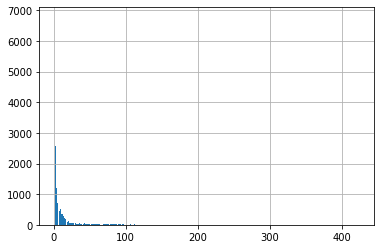

In [195]:
df['linked_page_title'].value_counts().hist(bins = 500)

In [ ]:
df